In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [5]:
data = pd.read_parquet('../data/bank-additional-full.parquet')

# Available columns

Firstly a short description of all the input features, taken from the provided data information.

## bank client data:

1. age (numeric)
2. job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
3. marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
4. education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
5. default: has credit in default? (categorical: "no","yes","unknown")
6. housing: has housing loan? (categorical: "no","yes","unknown")
7. loan: has personal loan? (categorical: "no","yes","unknown")

## related with the last contact of the current campaign:
8. contact: contact communication type (categorical: "cellular","telephone")·
9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
10. day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")

## other attributes:
11. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
12. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
13. previous: number of contacts performed before this campaign and for this client (numeric)
14. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

## social and economic context attributes
15. emp.var.rate: employment variation rate - quarterly indicator (numeric)
16. cons.price.idx: consumer price index - monthly indicator (numeric)
17. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
18. euribor3m: euribor 3 month rate - daily indicator (numeric)
19. nr.employed: number of employees - quarterly indicator (numeric)

# Overview of each input feature

The first step is to get an overview of the data. For that I use seaborns pairplot, which creates scatter plots
for each pair of columns.

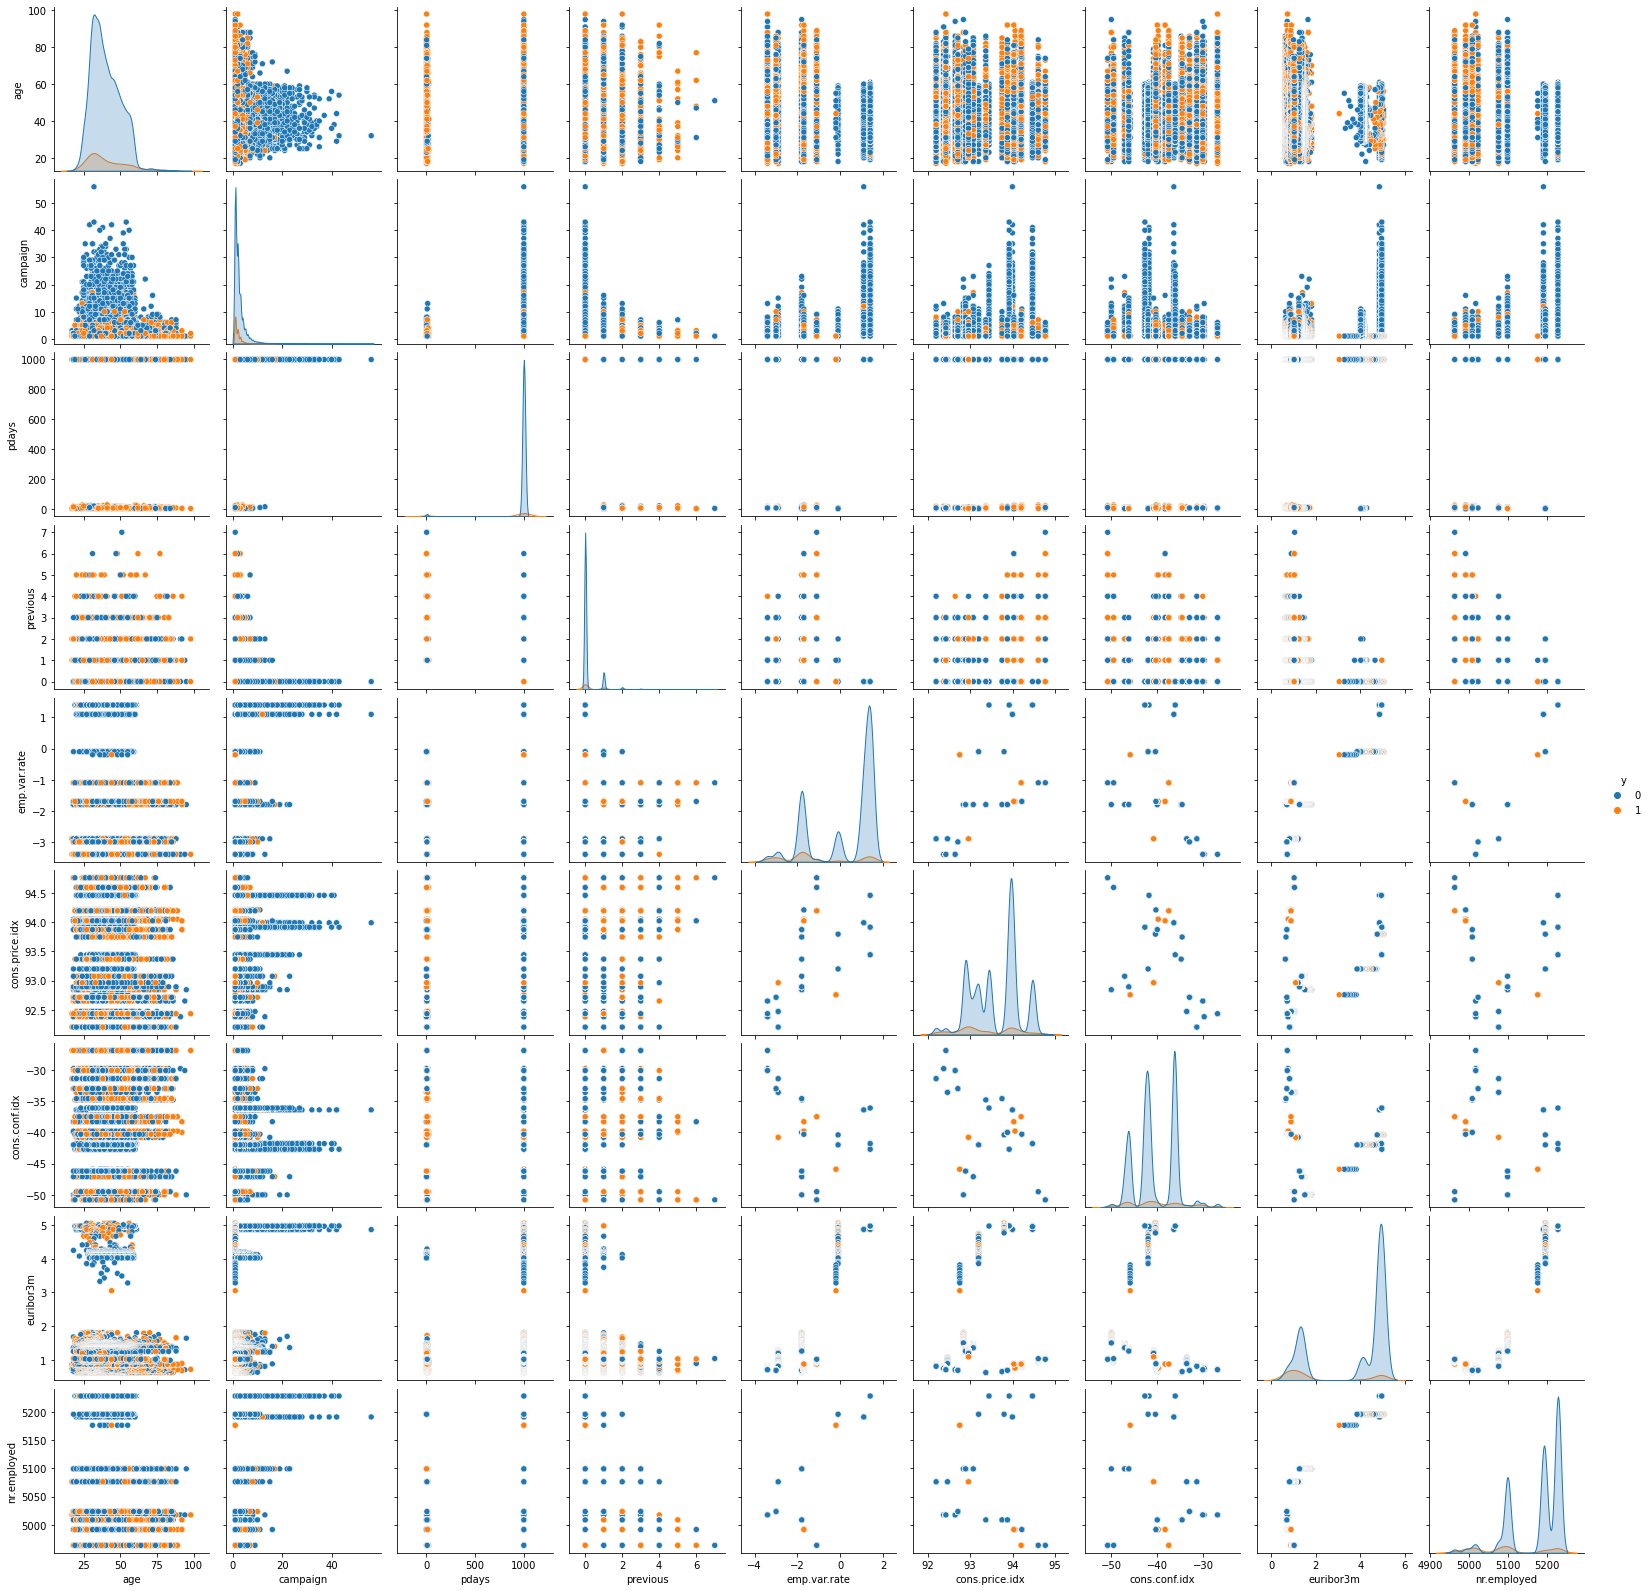

In [3]:
sns.pairplot(data, hue='y');

Now I go through every feature and check for:
* any outliers
* if some categorial variables have too many classes
* dependence to target variable
* if any domain transformation would help to make the distribution more 'normal'
* anything which looks interesting

## Age

* average age is similar for positive and negative case
* but histogram shows that clients above 60, have a higher chance of accepting the offer

In [4]:
# mean and median age vs. target
data.groupby('y')['age'].agg(['mean', 'median', 'std'])

,mean,median,std
y,,,
0,39.911185,38,9.898132
1,40.913147,37,13.837476


y
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

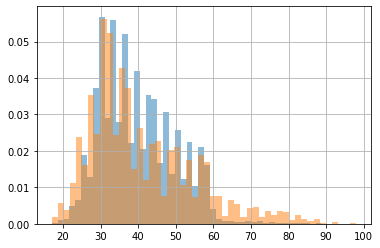

In [5]:
data.groupby('y')['age'].hist(bins=50, alpha=0.5, density=True)

In [6]:
# prob. for customers above 60 is 4 times higher
data[data['age'] > 60]['y'].mean()/data['y'].mean()

4.0384217506631295

## job

* students and retired have highest prob.
* all categories have enough samples to be used for training

### to try
* replace unknown with admin. (mode + similar prob.)
* use model to replace unknown

In [34]:
data['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

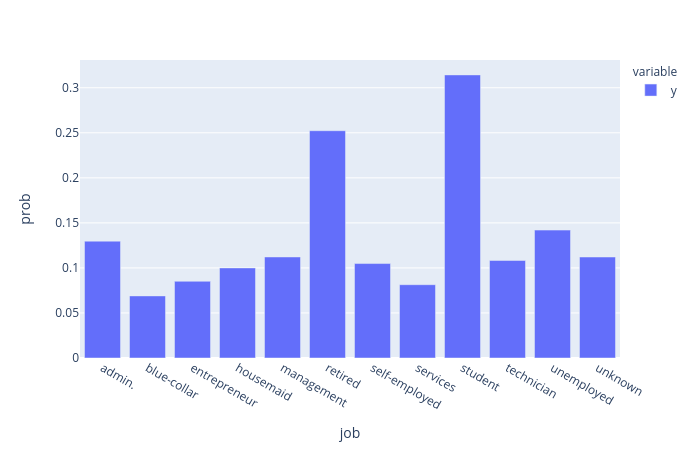

In [26]:
px.bar(
    data.groupby(['job'])['y'].mean(),
    labels={'value': 'prob'},
).show("png")

In [32]:
set(data['job'].unique()) - set(data['job'].unique())

set()

## marital

* very few 'unknown' cases

### to try
* maybe replace 'unknown' with married (mode) or single (similar prob.);
* fit model to replace unknown

In [9]:
data['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

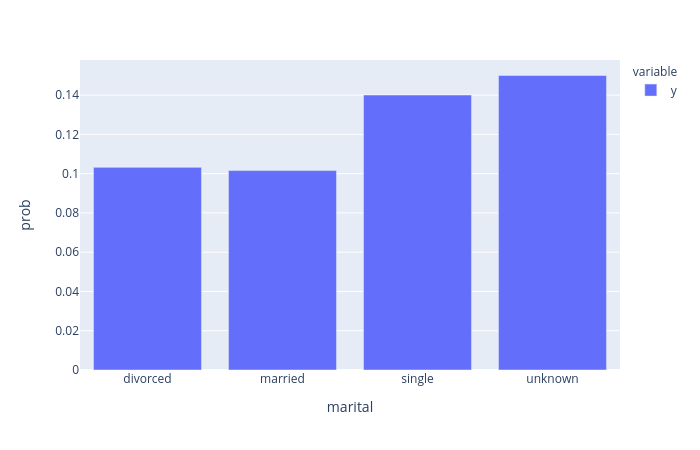

In [9]:
px.bar(
    data.groupby(['marital'])['y'].mean(),
    labels={'value': 'prob'},
).show("png")

## education

* almost no illiterate cases; high prob. is maybe due to low statistics

### to try
* replace illiterate with mode or model

In [11]:
data['education'].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

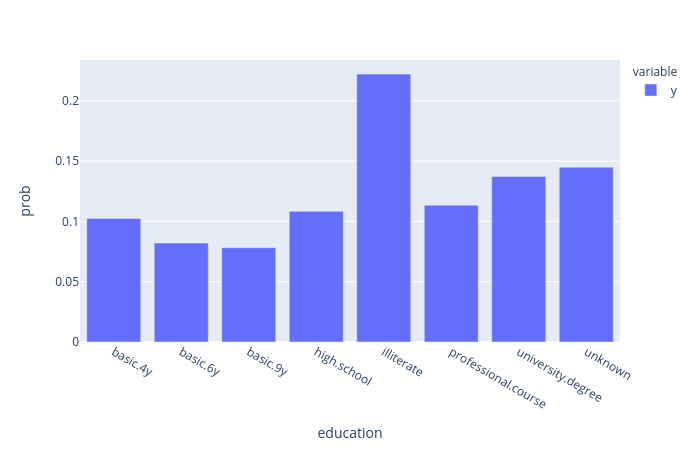

In [10]:
px.bar(
    data.groupby(['education'])['y'].mean(),
    labels={'value': 'prob'},
).show("png")

## default

* only three 'yes' cases, too few to be useful for the model;

### to try
*  drop column
* set 'yes' to 'unknown'

In [13]:
data['default'].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

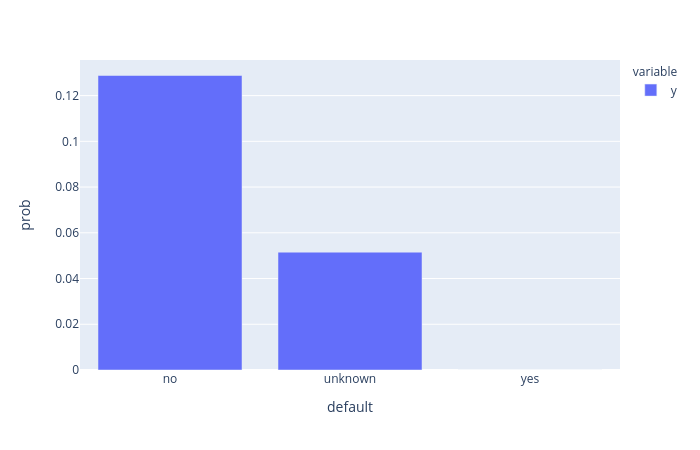

In [11]:
px.bar(
    data.groupby(['default'])['y'].mean(),
    labels={'value': 'prob'},
).show("png")

## loan

* enough samples for each class
* very similar prob. in all classes

In [15]:
data['loan'].value_counts()

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

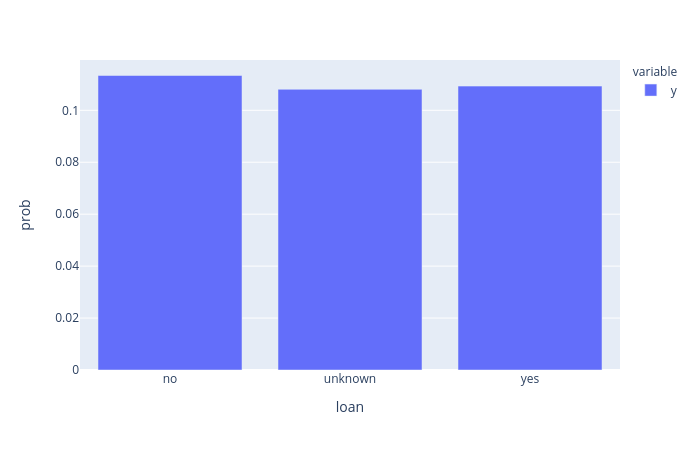

In [12]:
px.bar(
    data.groupby(['loan'])['y'].mean(),
    labels={'value': 'prob'},
).show("png")

## contact

* quite a huge difference in prob. between 'cellular' and 'telephone'

In [17]:
data['contact'].value_counts()

cellular     26144
telephone    15044
Name: contact, dtype: int64

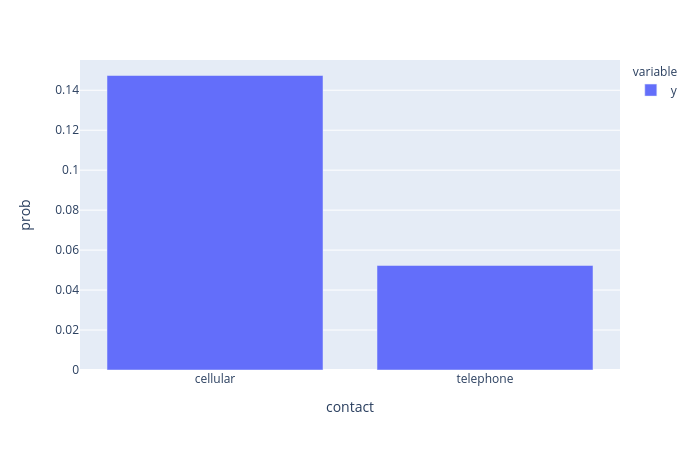

In [13]:
px.bar(
    data.groupby(['contact'])['y'].mean(),
    labels={'value': 'prob'},
).show("png")

## month

* very different number of attempts, peak in may,
* especially the month with a lot of attemps have a very low prob; maybe the amount influences the likelohod of success
  which means the feature might not be useful for prediction, and result on test set may be flawed

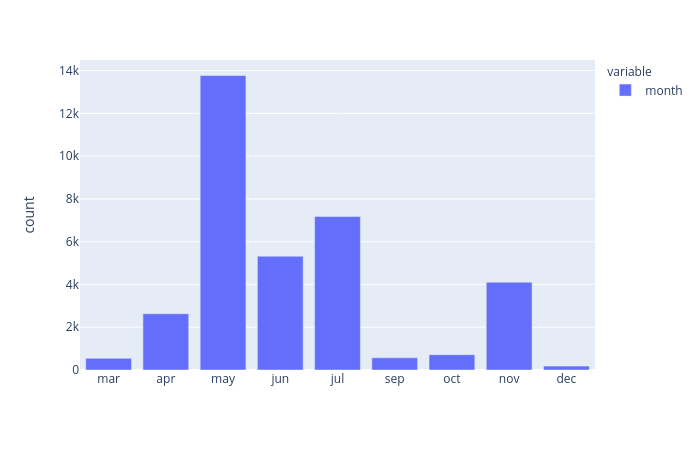

In [14]:
px.bar(
    data['month'].value_counts().reindex(['mar', 'apr', 'may', 'jun', 'jul', 'sep', 'oct', 'nov', 'dec']),
    labels={'value': 'count', 'index': ''}
).show("png")

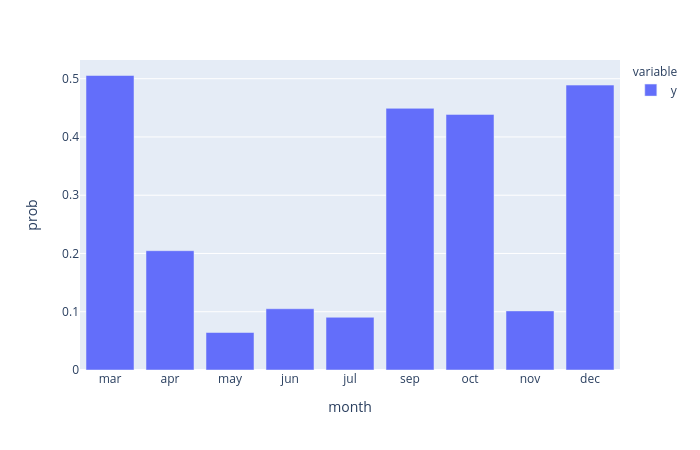

In [15]:
px.bar(
    data.groupby(['month'])['y'].mean().reindex(['mar', 'apr', 'may', 'jun', 'jul', 'sep', 'oct', 'nov', 'dec']),
    labels={'value': 'prob'},
).show("png")

In [21]:
data['month'].value_counts().to_frame('COUNT').join(
    data.groupby(['month'])['y'].mean().to_frame('PROB')
).reindex(['mar', 'apr', 'may', 'jun', 'jul', 'sep', 'oct', 'nov', 'dec'])

,COUNT,PROB
mar,546,0.505495
apr,2632,0.204787
may,13769,0.064347
jun,5318,0.105115
jul,7174,0.090466
sep,570,0.449123
oct,718,0.438719
nov,4101,0.101439
dec,182,0.489011


In [22]:
# prob. versus number of attempts per month
# very high dependence
data['month'].value_counts().to_frame('COUNT').join(
    data.groupby(['month'])['y'].mean().to_frame('PROB')
)

,COUNT,PROB
may,13769,0.064347
jul,7174,0.090466
aug,6178,0.106021
jun,5318,0.105115
nov,4101,0.101439
apr,2632,0.204787
oct,718,0.438719
sep,570,0.449123
mar,546,0.505495
dec,182,0.489011


In [23]:
data['month'].value_counts().to_frame('COUNT').join(
    data.groupby(['month'])['y'].mean().to_frame('PROB')
).corr()

,COUNT,PROB
COUNT,1.000000,-0.810992
PROB,-0.810992,1.000000


## day_of_week

* equally distributed over 5 work days

In [24]:
data['day_of_week'].value_counts()

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64

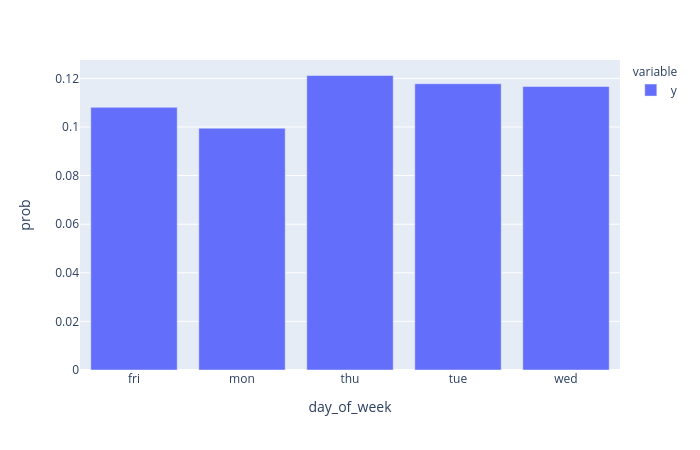

In [16]:
px.bar(
    data.groupby(['day_of_week'])['y'].mean(),
    labels={'value': 'prob'},
).show("png")

## campaign

* no outliers
* could be used as is

In [26]:
data.groupby('y')['campaign'].agg(['mean', 'median', 'std'])

,mean,median,std
y,,,
0,2.633085,2,2.873438
1,2.051724,2,1.666245


y
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: campaign, dtype: object

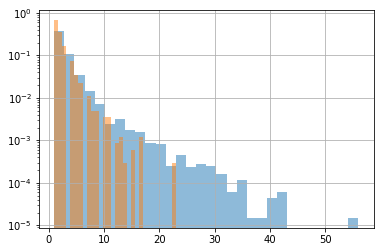

In [27]:
data.groupby('y')['campaign'].hist(bins=30, alpha=0.5, density=True, log=True)

## pdays

* 999 -> no previous contacts

### to try
* set 999 to -1

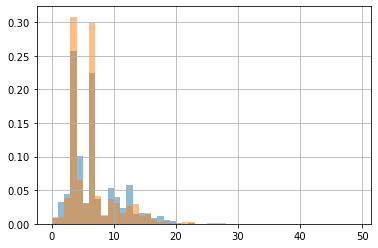

In [28]:
data.groupby('y')['pdays'].hist(bins=np.arange(0, 50), alpha=0.5, density=True);

## previous

* no outliers

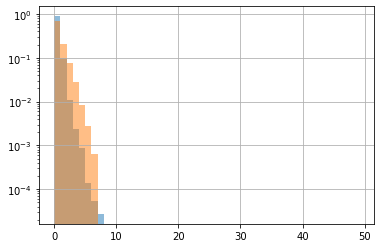

In [29]:
data.groupby('y')['previous'].hist(bins=np.arange(0, 50), alpha=0.5, density=True, log=True);

## poutcome

* if previous attempt was a success, new attempt has a high success prob.

In [30]:
data['poutcome'].value_counts()

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

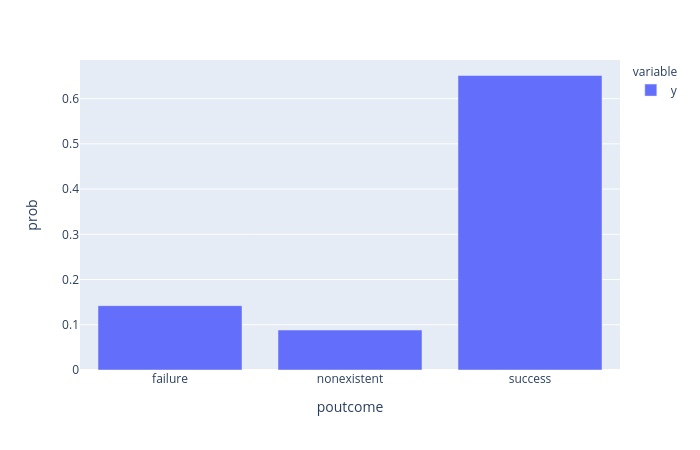

In [17]:
px.bar(
    data.groupby(['poutcome'])['y'].mean(),
    labels={'value': 'prob'},
).show("png")

## social and economic context attributes

All following context attributes are measured either quaterly or monthly. This means they are highly correlated to
the month, from which we already know that it might be flawed. Month with less attempts have a much higher
success rate than month with more attempts; this may translate to these attributes.

## emp.var.rate

* low cardinatity: could be used as categorial
* lower value -> higher prob., but fluctuates quite a log

In [32]:
data['emp.var.rate'].value_counts().sort_index()

-3.4     1071
-3.0      172
-2.9     1663
-1.8     9184
-1.7      773
-1.1      635
-0.2       10
-0.1     3683
 1.1     7763
 1.4    16234
Name: emp.var.rate, dtype: int64

In [33]:
data.groupby('emp.var.rate')['y'].mean()

emp.var.rate
-3.4    0.423903
-3.0    0.511628
-2.9    0.357186
-1.8    0.159081
-1.7    0.521345
-1.1    0.474016
-0.2    0.100000
-0.1    0.062992
 1.1    0.030916
 1.4    0.053345
Name: y, dtype: float64

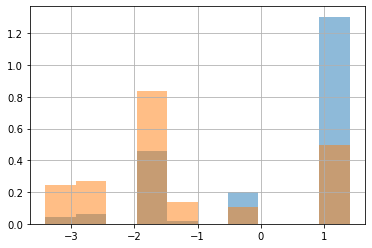

In [34]:
data.groupby('y')['emp.var.rate'].hist(bins=10, alpha=0.5, density=True);

## cons.price.idx

In [19]:
data.groupby('cons.price.idx')['y'].mean().to_frame('prob').join(
    data.groupby('cons.price.idx').size().to_frame('count')
)

,prob,count
cons.price.idx,,
92.201,0.342857,770
92.379,0.397004,267
92.431,0.402685,447
92.469,0.370787,178
92.649,0.470588,357
92.713,0.511628,172
92.756,0.100000,10
92.843,0.446809,282
92.893,0.090438,5794


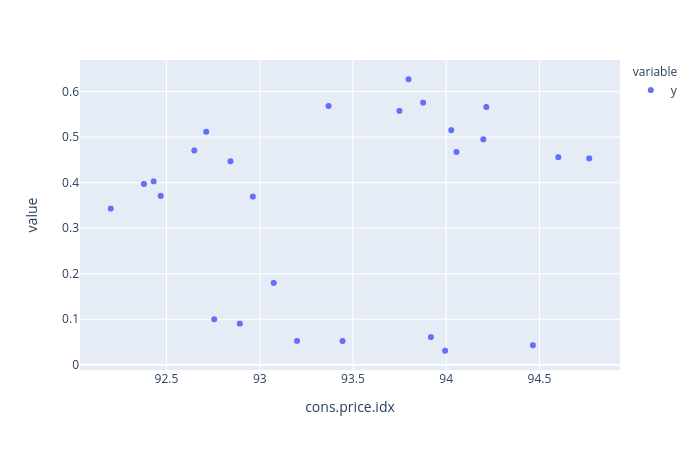

In [18]:
px.scatter(data.groupby('cons.price.idx')['y'].mean()).show("png")

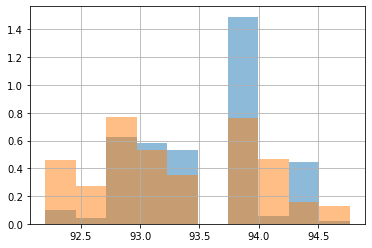

In [37]:
data.groupby('y')['cons.price.idx'].hist(bins=10, alpha=0.5, density=True);

## cons.conf.idx

In [38]:
data['cons.conf.idx'].value_counts().sort_index()

-50.8     128
-50.0     282
-49.5     204
-47.1    2458
-46.2    5794
-45.9      10
-42.7    6685
-42.0    3616
-41.8    4374
-40.8     715
-40.4      67
-40.3     311
-40.0     212
-39.8     229
-38.3     233
-37.5     303
-36.4    7763
-36.1    5175
-34.8     264
-34.6     174
-33.6     178
-33.0     172
-31.4     770
-30.1     357
-29.8     267
-26.9     447
Name: cons.conf.idx, dtype: int64

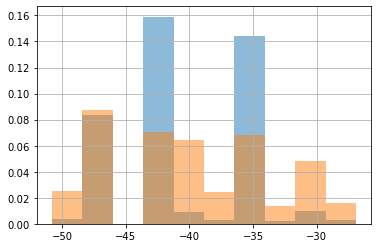

In [39]:
data.groupby('y')['cons.conf.idx'].hist(bins=10, alpha=0.5, density=True);

## euribor3m

* low cardinality: maybe use as categories

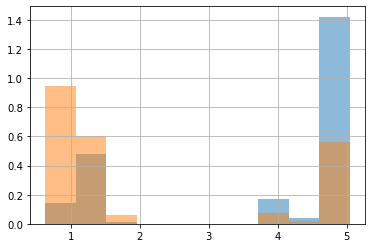

In [40]:
data.groupby('y')['euribor3m'].hist(bins=10, alpha=0.5, density=True);

## nr.employed

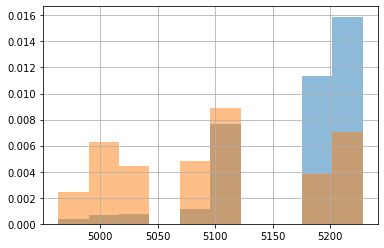

In [41]:
data.groupby('y')['nr.employed'].hist(bins=10, alpha=0.5, density=True);

## correlation with month

The variance in all but 'euribor3m' features is quite low.
They are strongly correlated with the month they are measured.

This means, although they could have a high predicitive power in general,
in this dataset is not enough data to learn from. Or in other words,
it is likely that a model just memorize these features.

In [20]:
sozioeco_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [21]:
data.groupby('month')[sozioeco_cols].nunique().reindex(
    ['mar', 'apr', 'may', 'jun', 'jul', 'sep', 'oct', 'nov', 'dec']
).join(
    data.groupby('month').size().to_frame('count')
).join(
    data.groupby('month')['y'].mean().to_frame('prob')
)

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,count,prob
month,,,,,,,
mar,1,2,2,37,2,546,0.505495
apr,1,2,2,29,2,2632,0.204787
may,2,3,3,35,3,13769,0.064347
jun,3,3,3,44,3,5318,0.105115
jul,3,3,3,51,3,7174,0.090466
sep,2,2,2,31,2,570,0.449123
oct,3,3,3,48,3,718,0.438719
nov,3,3,3,38,3,4101,0.101439
dec,2,2,2,22,2,182,0.489011


# Impute Unknown

TODO